In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Dense, Dropout

from sklearn.utils.class_weight import compute_class_weight

In [3]:
malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [4]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [11]:
from keras.layers import Bidirectional, LSTM, Embedding, Concatenate
from keras.layers import Layer
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
    
def build_and_train_model(df, max_features, maximum_length=100, embedding_dim=256, dropout_rate=0.5, lstm_units=60, dense=None, batch_size=16, epochs=20, verbose=0):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(df['Emotion']), y=df['Emotion'])
    class_weights = dict(enumerate(class_weights))

    # Preprocess features
    X_text = np.asarray(df['padded'].to_list())
    y = pd.get_dummies(df['Emotion']).values

    # Split data
    X_text_train, X_text_val, y_train, y_val = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

    text_input = Input(shape=(maximum_length,), dtype='int32', name='text_input')

    x = Embedding(input_dim=max_features, output_dim=embedding_dim)(text_input)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Attention()(x)

    if dense != None:
        x = Dense(dense, activation='relu')(x)
    outputs = Dense(y.shape[1], activation='softmax')(x)

    # Create and compile the model
    model = tf.keras.Model(text_input, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if verbose != 0:
        model.summary()

    # Train the model
    history = model.fit(
        X_text_train, y_train,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_text_val, y_val),
        class_weight=class_weights,
        verbose=verbose
    )
    return model, history

In [17]:
embeddings = [64,128]
dropouts = [0.3,0.4]
lstm_units = [30,60,120]
dense = [16,32,64,128]
batchs = [32,64,128,256]

best_accuracy = 0
best_params = {}
run_count = 1

for e in embeddings:
    for d in dropouts:
        for l in lstm_units:
            for de in dense:
                for b in batchs:
                    print(f"{run_count} : Training with embedding_dim={e}, dropout_rate={d}, lstm_units={l}, dense_layer={de}, batch_size={b}")
                    model, history = build_and_train_model(processed_data, tokenizer_features, maximum_length=100, embedding_dim=e, dropout_rate=d, lstm_units=l, dense=de, batch_size=b, epochs=20)
                    
                    val_accuracy = history.history['val_accuracy'][-1]
                    top_val_accuracy = max(history.history['val_accuracy'])
                    ind = np.argmax(history.history['val_accuracy'])
                    print(f"Value accuracy: {val_accuracy}.  Top accuracy: {top_val_accuracy} at epoch: {ind}")
                    if top_val_accuracy > best_accuracy:
                        best_accuracy = top_val_accuracy
                        best_params = {'embedding_dim': e, 'dropout_rate': d, 'lstm_unit': l, 'dense': de, 'batch_size': b, 'epoch': ind}
                    run_count += 1 

print(f"Best validation accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")

1 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=16, batch_size=32
Value accuracy: 0.219730943441391.  Top accuracy: 0.219730943441391 at epoch: 19
2 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=16, batch_size=64
Value accuracy: 0.1031390130519867.  Top accuracy: 0.2331838607788086 at epoch: 0
3 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=16, batch_size=128
Value accuracy: 0.14798206090927124.  Top accuracy: 0.17488789558410645 at epoch: 17
4 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=16, batch_size=256
Value accuracy: 0.16591928899288177.  Top accuracy: 0.21076233685016632 at epoch: 14
5 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=32, batch_size=32
Value accuracy: 0.2735426127910614.  Top accuracy: 0.2959641218185425 at epoch: 15
6 : Training with embedding_dim=64, dropout_rate=0.3, lstm_units=30, dense_layer=32, ba

In [18]:
print(f"Best parameters: {best_params}")
# best_params = {'embedding_dim': 128, 'dropout_rate': 0.4, 'lstm_unit': 60, 'batch_size': 128, 'epoch': 20, 'dense': 32}
model, history = build_and_train_model(processed_data, tokenizer_features, maximum_length=100, embedding_dim=best_params['embedding_dim'], dropout_rate=best_params['dropout_rate'], lstm_units=best_params['lstm_unit'], dense=best_params['dense'], batch_size=best_params['batch_size'], epochs=best_params['epoch'], verbose=1)

Best parameters: {'embedding_dim': 64, 'dropout_rate': 0.3, 'lstm_unit': 30, 'dense': 32, 'batch_size': 32, 'epoch': 15}


Model: "functional_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_222 (Embedding)       │ (None, 100, 64)        │     1,953,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_222               │ (None, 100, 60)        │        22,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_222 (Attention)       │ (None, 60)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 32)             │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,978,584 (7.55 MB)

 Trainable params: 1,978,584 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0966 - loss: 2.0749 - val_accuracy: 0.1749 - val_loss: 2.0813
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1669 - loss: 2.0224 - val_accuracy: 0.0942 - val_loss: 2.0848
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1131 - loss: 2.0450 - val_accuracy: 0.1704 - val_loss: 2.0792
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1463 - loss: 2.1018 - val_accuracy: 0.1031 - val_loss: 2.0892
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.1225 - loss: 2.0706 - val_accuracy: 0.0942 - val_loss: 2.1165
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.1301 - loss: 1.9347 - val_accuracy: 0.1345 - val_loss: 2.0858
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1889 - loss: 1.7943 - val_accuracy: 0.1256 - val_loss: 2.0871
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.2808 - loss: 1.6850 - val_accuracy: 0.1435 - v

Training with embedding_dim=64, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=64, dropout_rate=0.1, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.1, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.1, batch_size=64
Value accuracy: 0.3928571343421936
Training with embedding_dim=64, dropout_rate=0.1, batch_size=128
Value accuracy: 0.2678571343421936
Training with embedding_dim=64, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2142857164144516
Training with embedding_dim=64, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2232142835855484
Training with embedding_dim=64, dropout_rate=0.2, batch_size=32
Value accuracy: 0.3839285671710968
Training with embedding_dim=64, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2946428656578064
Training with embedding_dim=64, dropout_rate=0.3, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=64, dropout_rate=0.3, batch_size=32
Value accuracy: 0.375
Training with embedding_dim=64, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3125
Training with embedding_dim=64, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3660714328289032
Training with embedding_dim=64, dropout_rate=0.4, batch_size=8
Value accuracy: 0.3035714328289032
Training with embedding_dim=64, dropout_rate=0.4, batch_size=16
Value accuracy: 0.3125
Training with embedding_dim=64, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=64, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=64, dropout_rate=0.5, batch_size=8
Value accuracy: 0.3303571343421936
Training with embedding_dim=64, dropout_rate=0.5, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.5, batch_size=32
Value accuracy: 0.2589285671710968
Training with embedding_dim=64, dropout_rate=0.5, batch_size=64
Value accuracy: 0.3839285671710968
Training with embedding_dim=64, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3660714328289032
Training with embedding_dim=128, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2678571343421936
Training with embedding_dim=128, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=128, dropout_rate=0.1, batch_size=64
Value accuracy: 0.3839285671710968
Training with embedding_dim=128, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=128, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2678571343421936
Training with embedding_dim=128, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=128, dropout_rate=0.2, batch_size=128
Value accuracy: 0.3392857015132904
Training with embedding_dim=128, dropout_rate=0.3, batch_size=8
Value accuracy: 0.3125
Training with embedding_dim=128, dropout_rate=0.3, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.3, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3303571343421936
Training with embedding_dim=128, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=128, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=128, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2142857164144516
Training with embedding_dim=128, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.4, batch_size=128
Value accuracy: 0.4107142984867096
Training with embedding_dim=128, dropout_rate=0.5, batch_size=8
Value accuracy: 0.3214285671710968
Training with embedding_dim=128, dropout_rate=0.5, batch_size=16
Value accuracy: 0.3125
Training with embedding_dim=128, dropout_rate=0.5, batch_size=32
Value accuracy: 0.3482142984867096
Training with embedding_dim=128, dropout_rate=0.5, batch_size=64
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.5, batch_size=128
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=256, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2321428507566452
Training with embedding_dim=256, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2678571343421936
Training with embedding_dim=256, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=256, dropout_rate=0.2, batch_size=16
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2410714328289032
Training with embedding_dim=256, dropout_rate=0.2, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=256, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2678571343421936
Training with embedding_dim=256, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.3, batch_size=16
Value accuracy: 0.25
Training with embedding_dim=256, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=256, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=256, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2232142835855484
Training with embedding_dim=256, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2321428507566452
Training with embedding_dim=256, dropout_rate=0.4, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=256, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3125
Training with embedding_dim=256, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3303571343421936
Training with embedding_dim=256, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.5, batch_size=32
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.5, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=512, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2857142984867096
Training with embedding_dim=512, dropout_rate=0.1, batch_size=16
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.1, batch_size=32
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2321428507566452
Training with embedding_dim=512, dropout_rate=0.1, batch_size=128
Value accuracy: 0.2589285671710968
Training with embedding_dim=512, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=512, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2946428656578064
Training with embedding_dim=512, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2053571492433548
Training with embedding_dim=512, dropout_rate=0.3, batch_size=16
Value accuracy: 0.1875
Training with embedding_dim=512, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2857142984867096
Training with embedding_dim=512, dropout_rate=0.3, batch_size=64
Value accuracy: 0.2678571343421936
Training with embedding_dim=512, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=512, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.4, batch_size=16
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2678571343421936
Training with embedding_dim=512, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=512, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=512, dropout_rate=0.5, batch_size=32
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.5, batch_size=64
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3035714328289032
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=16
Value accuracy: 0.2678571343421936
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=64
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3303571343421936
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=8
Value accuracy: 0.25
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=64
Value accuracy: 0.2232142835855484
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2678571343421936
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=32
Value accuracy: 0.25
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=64
Value accuracy: 0.2589285671710968
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=128
Value accuracy: 0.2857142984867096
Best validation accuracy: 0.4107142984867096
Best parameters: {'embedding_dim': 128, 'dropout_rate': 0.4, 'batch_size': 128}

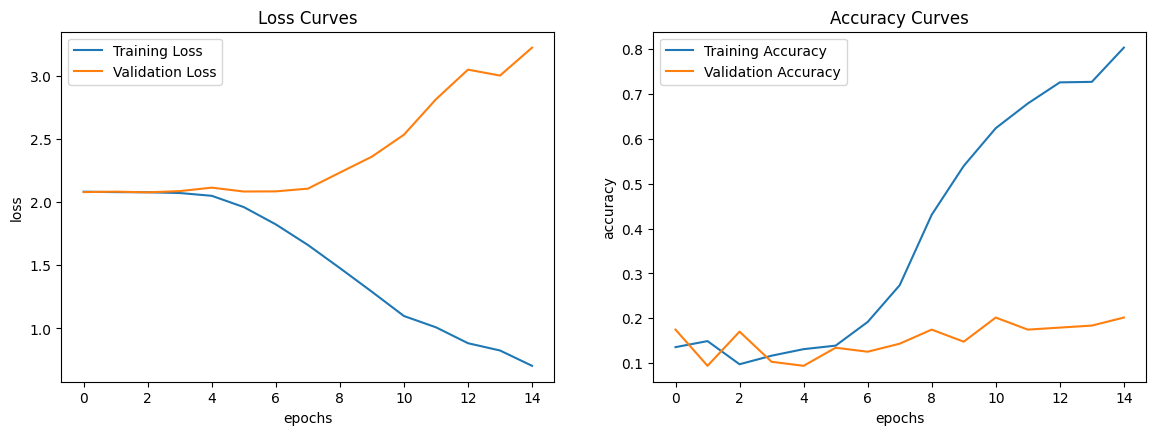

In [19]:
tr_loss = history.history[ 'loss']
val_loss = history.history['val_loss']
tr_acc = history.history[ 'accuracy']
val_acc = history.history[ 'val_accuracy']
epochs = range(len(tr_loss)) # get the epochs as a list to plot along the x-axis

plt.figure(figsize=(14,10))
# Loss curves
ax = plt.subplot(2,2,1)
plt.plot(epochs, tr_loss, label='Training Loss') 
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curves')
plt.legend()
# Accuracy curves
ax = plt.subplot(2,2,2)
plt.plot(epochs, tr_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Curves')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
              precision    recall  f1-score   support

       trust       0.22      0.22      0.22        23
     disgust       0.24      0.45      0.31        20
anticipation       0.18      0.08      0.11        25
     sadness       0.00      0.00      0.00         4
       anger       0.17      0.10      0.12        10
        fear       0.20      0.07      0.11        14
    surprise       0.21      0.33      0.26         9
         joy       0.23      0.43      0.30         7

    accuracy                           0.21       112
   macro avg       0.18      0.21      0.18       112
weighted avg       0.20      0.21      0.19       112



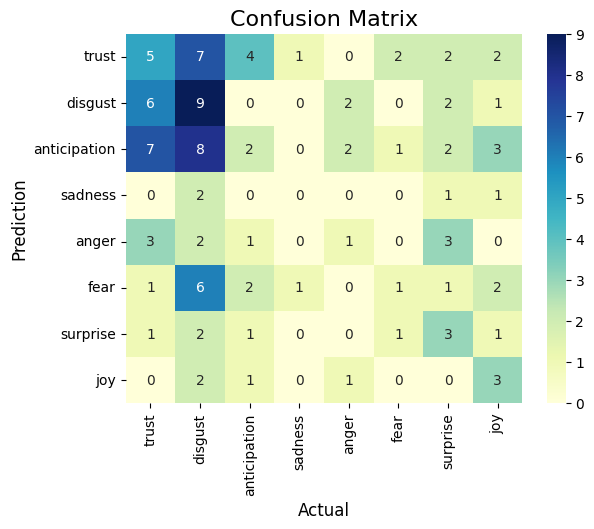

In [20]:
X_text = np.asarray(processed_data['padded'].to_list())
y = pd.get_dummies(processed_data['Emotion']).values

X_text_train, X_text_val, y_train, y_val = train_test_split(
        X_text, y, test_size=0.1, random_state=42, stratify=y
    )

labels = processed_data["Emotion"].unique().tolist()

y_pred = model.predict(X_text_val)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_val, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()